# Applying Deep learning concepts for text classification

We shall use keras and tensorflow for this excercise

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import re    # for regular expressions 
import nltk  # for text manipulation 
from nltk.corpus import stopwords
import string 
import pandas as pd
import pickle
import numpy as np
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

Using TensorFlow backend.


# 2)- Working on Data

In [4]:
dataset=pd.read_pickle('data_clean.pkl')

In [5]:
dataset.head()

,label,sms,clean,cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",until jurong point crazy Available only bugis ...,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,Joking,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry wkly comp final tkts Text receive e...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,early already then,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",think go life around here though,nah think go usf life around though


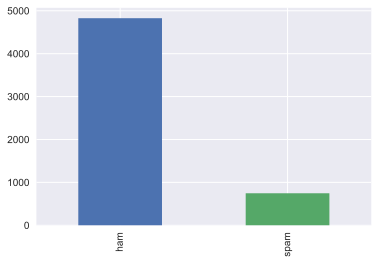

In [6]:
dataset.label.value_counts().plot(kind='bar')

### 2.1)- Taking only concerned features

In [7]:
X=dataset['cleaned']
Y=dataset['label']

### 2.2)-Convert words to matrix

We need to convert words into matrices. One way is shown through sklearn. Other way is given. We can always match the two

**i-I started by fitting a tokenizer on my document as in here:**

In [8]:
# Fitting
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X)

**ii- I wanted to check if my data is fitted correctly so I converted into sequence**

In [9]:
# convert to sequence
X_token = tokenizer.texts_to_sequences(X)

In [10]:
pd.DataFrame(X_token).head()

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,6.0,279.0,598.0,514.0,1103.0,27.0,63.0,231.0,835.0,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8.0,245.0,1257.0,359.0,1.0,1622.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,351.0,627.0,719.0,85.0,1623.0,836.0,515.0,1624.0,162.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,159.0,59.0,280.0,1.0,29.0,83.0,59.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,837.0,43.0,6.0,771.0,88.0,138.0,360.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
dataset['cleaned'][0]

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

It means that "go" is encoded as 6.0, "jurong" as 279 and so on...... "point" as 598.0 and finally "great" as 231.0

In [12]:
dataset['cleaned'][4]

'nah think go usf life around though'

"nah" as 837.0, "think" as 43.0......so you got the idea

**iii-pad_sequence:To keep all vectors of same length, I will use pad_sequence**

In [13]:
X_pd_sq = pad_sequences(X_token)

To avoid AttributeError: 'numpy.ndarray' object has no attribute 'head', we will check in dataframe. Still input to neural network will be numpy array not dataframe

In [14]:
pd.DataFrame(X_pd_sq).head()

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0,0,0,0,0,0,0,0,0,0,...,514,1103,27,63,231,835,78,1104,16,72
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,245,1257,359,1,1622
2,0,0,0,0,0,0,0,0,0,0,...,17,1623,246,351,274,770,25,221,29,297
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,159,59,280,1,29,83,59
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,837,43,6,771,88,138,360


In [15]:
X_pd_sq.shape

(5574, 62)

**combining in one step**

In [16]:
#max_fatures = 2000
#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
#tokenizer.fit_on_texts(X)
#X = tokenizer.texts_to_sequences(X)
#X = pad_sequences(X)

### 2.3- Train-test split

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pd_sq, Y, random_state=2019)

In [18]:
X_train.shape, X_test.shape

((4180, 62), (1394, 62))

In [19]:
print(y_train.shape)
print(y_test.shape)

(4180,)
(1394,)


### 2.4)-Encoding y-labeled feature

In [20]:
# keras needs inputs to be vectors , so one hot encoding values
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

**this step is very important as we need to decode categorical variables into dummy**

In [21]:
print(y_train[:5])

4641    ham
4627    ham
1753    ham
4858    ham
4688    ham
Name: label, dtype: object


In [22]:
y_train_ohe[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [23]:
y_test[:5]

454      ham
3466     ham
581      ham
2231     ham
2959    spam
Name: label, dtype: object

In [24]:
y_test_ohe[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [25]:
unique_y_labels = list(y_train.value_counts().index)
unique_y_labels

['ham', 'spam']

In [26]:
len(unique_y_labels)

2

**Hence , our last dense layer will be of size 2**

# 3)-Build LSTM model

In [27]:
embed_dim = 128
lstm_out = 196
max_fatures = 2000
size_of_each_vect=X_train.shape[1]
uniq_y_label=len(unique_y_labels)

In [28]:
X_train.shape[1]

62

In [29]:
len(unique_y_labels)

2

In [30]:
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = size_of_each_vect))
# X.shape[1] refers to 23 columns 
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(uniq_y_label,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 62, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 62, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


### 3.1)-Train model

In [31]:
batch_size = 32
epochs = 20

In [32]:
from keras.callbacks import EarlyStopping

In [33]:
history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 3762 samples, validate on 418 samples
Epoch 1/20
3762/3762 [==============================] - 7s 2ms/step - loss: 0.1725 - acc: 0.9405 - val_loss: 0.0735 - val_acc: 0.9761
Epoch 2/20
3762/3762 [==============================] - 6s 2ms/step - loss: 0.0387 - acc: 0.9902 - val_loss: 0.0624 - val_acc: 0.9809
Epoch 3/20
3762/3762 [==============================] - 6s 2ms/step - loss: 0.0241 - acc: 0.9934 - val_loss: 0.0747 - val_acc: 0.9785
Epoch 4/20
3762/3762 [==============================] - 6s 2ms/step - loss: 0.0170 - acc: 0.9955 - val_loss: 0.0793 - val_acc: 0.9809
Epoch 5/20
3762/3762 [==============================] - 6s 2ms/step - loss: 0.0123 - acc: 0.9965 - val_loss: 0.0949 - val_acc: 0.9833


# 4)- Evaluate

In [34]:
y_pred = model.predict(X_test)

In [35]:
y_pred[:5]

array([[9.9997163e-01, 2.8369104e-05],
       [9.9996257e-01, 3.7429923e-05],
       [9.9997139e-01, 2.8653672e-05],
       [9.9995506e-01, 4.4970941e-05],
       [1.6423236e-09, 1.0000000e+00]], dtype=float32)

These are probabilities of output for class 0 and class1

In [36]:
y_test_ohe[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [37]:
## predict crisp classes for test set. Output will be 1-D
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

**Converting prob. into crisp classes i.e in 1D.**

In [38]:
y_test_class[:5]

array([0, 0, 0, 0, 1], dtype=int64)

By comparing from y_test_ohe, we can see that '1' in y_test_class means spam. 

0 means ham

In [39]:
y_pred_class[:5]

array([0, 0, 0, 0, 1], dtype=int64)

### a)- Classification Report

In [40]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1215
           1       1.00      0.85      0.92       179

   micro avg       0.98      0.98      0.98      1394
   macro avg       0.99      0.93      0.96      1394
weighted avg       0.98      0.98      0.98      1394



0 is ham<br>
1 is spam 

### b)-Confusion Matrix

In [41]:
import itertools
from sklearn import metrics
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_class,y_pred_class)
cm

array([[1215,    0],
       [  26,  153]], dtype=int64)

In [43]:
#save confusion matrix and slice into four piece
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

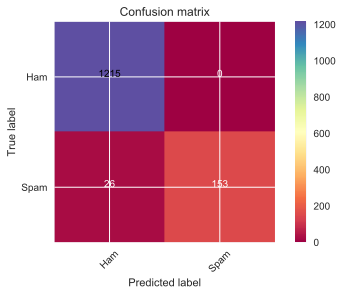

In [44]:
# False=0; True=1 ====> Ham=0, Spam=1
plot_confusion_matrix(cm, classes=['Ham', 'Spam'])

### c. Classification Accuracy

In [45]:
metrics.accuracy_score(y_test_class,y_pred_class)

0.9813486370157819

In [46]:
print((TP + TN) / float(TP + TN + FP + FN))

0.9813486370157819


**As we did our base model. We may do evaluation of other matrics**

### c)- Loss and Accuracy

In [47]:
loss, accuracy = model.evaluate(X_train, y_train_ohe, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

Training Accuracy: 0.9962
Training Loss: 0.0170


In [48]:
loss, accuracy = model.evaluate(X_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.9813
Testing Loss:  0.0852


In [49]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

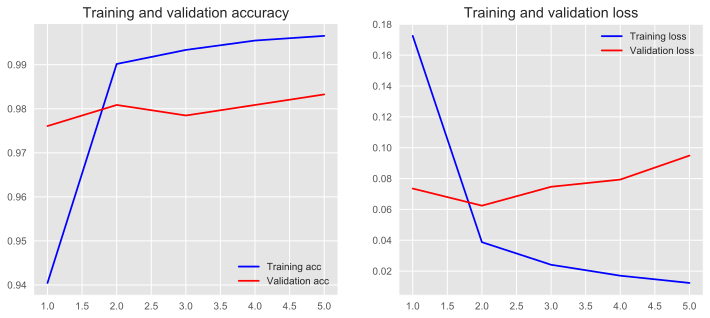

In [50]:
plot_history(history)

### d)- Checking results test set

In [51]:
y_test[:5]

454      ham
3466     ham
581      ham
2231     ham
2959    spam
Name: label, dtype: object

In [52]:
y_test_ohe[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [53]:
prediction=model.predict(X_test)
prediction[:5]

array([[9.9997163e-01, 2.8369104e-05],
       [9.9996257e-01, 3.7429923e-05],
       [9.9997139e-01, 2.8653672e-05],
       [9.9995506e-01, 4.4970941e-05],
       [1.6423236e-09, 1.0000000e+00]], dtype=float32)

In [54]:
# checking with original text at index 2165
dataset.sms.loc[2165]

"Nothing really, just making sure everybody's up to speed"

In [55]:
dataset.loc[2165]

label                                                    ham
sms        Nothing really, just making sure everybody's u...
clean        Nothing really just making sure everybody speed
cleaned           nothing really making sure everybody speed
Name: 2165, dtype: object

In [56]:
[print(dataset['sms'][i], y_pred[i], y_test_ohe[i]) for i in range(0, 5)]

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... [9.9997163e-01 2.8369104e-05] [1. 0.]
Ok lar... Joking wif u oni... [9.9996257e-01 3.7429923e-05] [1. 0.]
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's [9.9997139e-01 2.8653672e-05] [1. 0.]
U dun say so early hor... U c already then say... [9.9995506e-01 4.4970941e-05] [1. 0.]
Nah I don't think he goes to usf, he lives around here though [1.6423236e-09 1.0000000e+00] [0. 1.]


[None, None, None, None, None]

As we can see all five sms texts are non-spam and that is what our model has predicted